In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import folium
import matplotlib.pyplot as plt
% matplotlib inline

try:
    import seaborn as sns
except:
    print '"pip install seaborn" for prettier charts'

# Soundcast Travel Time Validation
- Uber travel times from 2016

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
# Origin zone
origin_zone = 522
model_dir = r'R:\SoundCast\releases\TransportationFutures2010'
max_internal_zone = 3700 #max internal zone to import

In [4]:
# Load Uber data
month = 'october_2015'

time_periods = ['am','md','pm','ev','ni']
observed = {}
for time_period in time_periods:
    observed[time_period] = pd.read_csv(r'../data/'+month+r'/'+str(origin_zone)+'/'+'am.csv')
    
    observed[time_period]['otaz'] = observed[time_period]['Source Display Name'].apply(
        lambda row: row.split(' ')[1]).astype('int')

    observed[time_period]['dtaz'] = observed[time_period]['Destination Display Name'].apply(
        lambda row: row.split(' ')[1]).astype('int')
    
    observed[time_period]['travel_time'] = observed[time_period]['Mean']/60
    observed[time_period]['travel_time_std'] = observed[time_period]['Standard Deviation']
    
    
    observed[time_period] = observed[time_period][['otaz','dtaz','travel_time','travel_time_std']]

In [5]:
# Scatter plot line
def scatter_plot_centerline(maxvalue):
    """
    Create numpy object to plot based on df values
    """
    return pd.DataFrame([0,maxvalue],[0,maxvalue]).plot(ax=ax, legend=False, color='grey')

In [6]:
# Load zone terminal times
# Just use the origin terminal time for all zones for now
o_tt = pd.read_csv(model_dir + r'\inputs\IntraZonals\origin_tt.in',
                   sep=' ',header=4)


o_tt.index = o_tt.index.get_level_values(1)
o_tt['taz'] = o_tt.index
o_tt['terminal_time'] = o_tt['matrix=mo"prodtt"']
o_tt = pd.DataFrame(o_tt[['terminal_time','taz']])

In [7]:
# Load travel time skims
skims_dir = model_dir + r'\inputs'

skims_tod = {'am': '7to8',
            'md': '10to14',
            'pm': '16to17',
            'ev': '18to20',
            'ni': '20to5'}

# User income class 2, hov2 for now
user_class = 'h2tl2t'

model = {}
for time_period, skim_name in skims_tod.iteritems():
    df = pd.DataFrame()
    
    h5_contents = h5py.File(skims_dir + r'\\' + skim_name + '.h5')
    
    df[user_class] = h5_contents['Skims'][user_class][:][origin_zone-1,:max_internal_zone]
    df['otaz'] = origin_zone
    df['dtaz'] = df.index+1
    df['travel_time'] = df[user_class]/100 # skim data is stored in hundreds
    
    # Subtract the terminal times
    df = pd.merge(df,o_tt,left_on='dtaz',right_on='taz')
    # Subtract destination terminal time
    df['travel_time'] = df['travel_time']-df['terminal_time']
    # Subtract origin terminal time
    df['travel_time'] = df['travel_time']-(o_tt[o_tt['taz'] == origin_zone]['terminal_time'].values[0])
    
    model[time_period] = df

# AM Travel Times
## From Seattle CBD

------------------------------------------
r-squared: 0.756465802333
------------------------------------------


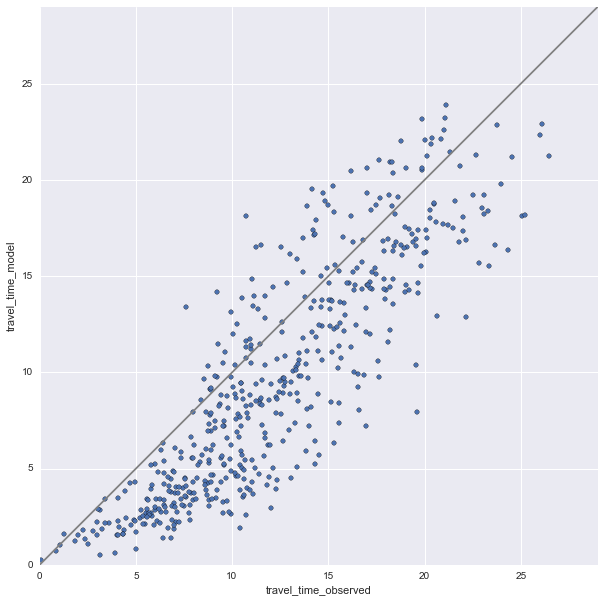

In [8]:
tod = 'am'
df = pd.merge(observed[tod],model[tod],on='dtaz',how='left', suffixes=['_observed','_model'])

# def scatter_plot(df):
# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
df.plot(kind='scatter', x='travel_time_observed', y='travel_time_model', ax=ax)

# Calcualte max value for sizing chart and adding centerline (add 10% to give extra room)
max_value = int(df[['travel_time_observed','travel_time_model']].max().max()*1.1)

# add a centerline, slope=1
scatter_plot_centerline(max_value)

# Set chart to be square with equal x and y axes
plt.xlim(0,max_value)
plt.ylim(0,max_value)

# Get R-squared value
r2 = pd.ols(y=df['travel_time_model'],x=df['travel_time_observed']).r2
print '------------------------------------------'
print 'r-squared: '  + str(r2)
print '------------------------------------------'

# Mid-Day Travel Times
## From Seattle CBD

------------------------------------------
r-squared: 0.781640438946
------------------------------------------


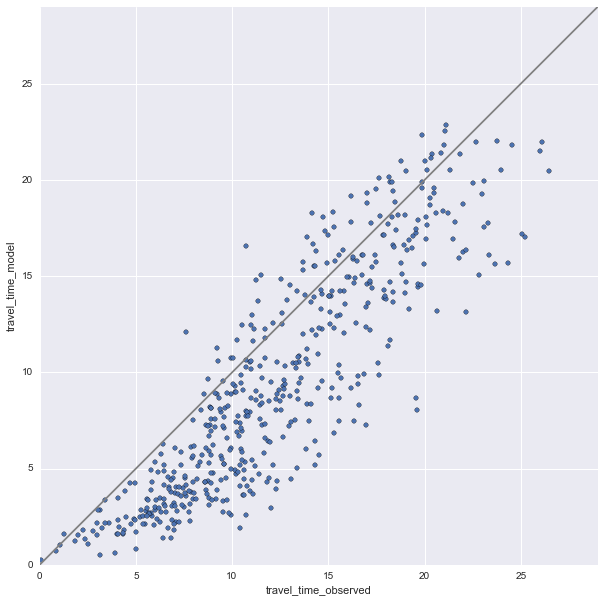

In [9]:
tod = 'md'
df = pd.merge(observed[tod],model[tod],on='dtaz',how='left', suffixes=['_observed','_model'])

# def scatter_plot(df):
# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
df.plot(kind='scatter', x='travel_time_observed', y='travel_time_model', ax=ax)

# Calcualte max value for sizing chart and adding centerline (add 10% to give extra room)
max_value = int(df[['travel_time_observed','travel_time_model']].max().max()*1.1)

# add a centerline, slope=1
scatter_plot_centerline(max_value)

# Set chart to be square with equal x and y axes
plt.xlim(0,max_value)
plt.ylim(0,max_value)

# Get R-squared value
r2 = pd.ols(y=df['travel_time_model'],x=df['travel_time_observed']).r2
print '------------------------------------------'
print 'r-squared: '  + str(r2)
print '------------------------------------------'

#PM Peak Travel Times
## From Seattle CBD

------------------------------------------
r-squared: 0.760597628648
------------------------------------------


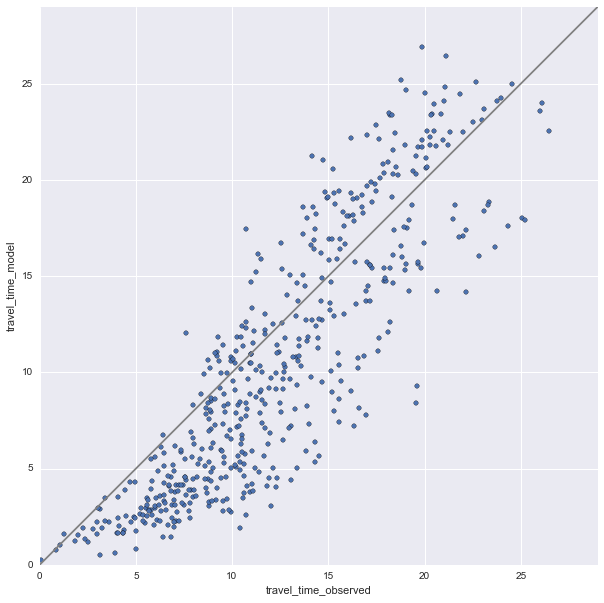

In [10]:
tod = 'pm'
df = pd.merge(observed[tod],model[tod],on='dtaz',how='left', suffixes=['_observed','_model'])

# def scatter_plot(df):
# Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
df.plot(kind='scatter', x='travel_time_observed', y='travel_time_model', ax=ax)

# Calcualte max value for sizing chart and adding centerline (add 10% to give extra room)
max_value = int(df[['travel_time_observed','travel_time_model']].max().max()*1.1)

# add a centerline, slope=1
scatter_plot_centerline(max_value)

# Set chart to be square with equal x and y axes
plt.xlim(0,max_value)
plt.ylim(0,max_value)

# Get R-squared value
r2 = pd.ols(y=df['travel_time_model'],x=df['travel_time_observed']).r2
print '------------------------------------------'
print 'r-squared: '  + str(r2)
print '------------------------------------------'

In [11]:
# Compare percent difference
df['%_diff'] = df['travel_time_model']-df['travel_time_observed']
# df['%_diff'].mean()

In [12]:
# df['%_diff'].mean()

# PM Peak Travel by Geography

In [13]:
# Get lookup table to see results by county destination, or district
geog = pd.read_csv(model_dir + r'\scripts\summarize\TAZ_TAD_County.csv')

In [14]:
df_geog = pd.merge(df,geog,left_on='dtaz',right_on='TAZ')

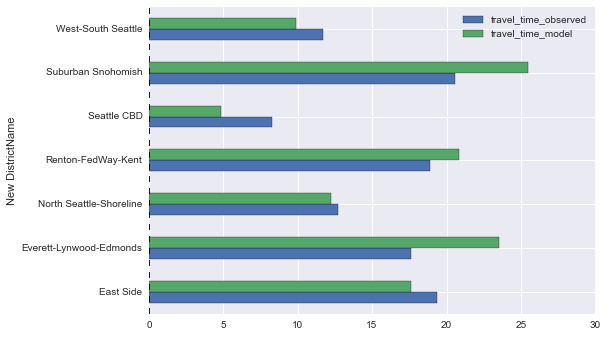

In [15]:
df_geog.groupby('New DistrictName').mean()[['travel_time_observed','travel_time_model']].plot(kind='barh')

# Largest OD Flows
- focus on freeway corridors only

In [16]:
taz = pd.read_csv(r'..\data\gis\taz2010_centroids.txt')
taz_df = pd.merge(df_geog, taz[['TAZ','lat','lon']], left_on='dtaz',right_on='TAZ',how='inner')

# find the largest OD flows from the given origin
daysim_outputs = h5py.File(model_dir + r'\outputs\daysim_outputs.h5')


daysim_trips = pd.DataFrame()
for field in ['otaz','dtaz','mode']:
    daysim_trips[field] = daysim_outputs['Trip'][field][:]

In [17]:
daysim_otaz_trips = daysim_trips[daysim_trips['otaz']==origin_zone]

In [18]:
# Get the top 10 destination TAZ
top_dtaz_list = daysim_otaz_trips.groupby('dtaz').count().sort('mode',ascending=False)[:15].index.values

# ignore trips to/from external zones
top_dtaz_list = top_dtaz_list[top_dtaz_list <= 3700]

In [19]:
top_df = df[df['dtaz'].isin(top_dtaz_list)]

# Compare percent difference
top_df['%_diff'] = top_df['travel_time_model']-top_df['travel_time_observed']
# top_df['%_diff'].mean()

In [20]:
map_osm = folium.Map(location=[47.636, -122.3750], zoom_start=11, tiles='Stamen Toner')

for taz_num in np.append(top_dtaz_list ,origin_zone):  # TAZ list plus the origin TAZ
    color='red'
    if taz_num==origin_zone:    # Map the origin in a different color
        color='green'
    coord = [taz_df[taz_df['dtaz'] == taz_num][col].values[0] for col in ['lat','lon']]
    icon = folium.Icon(color=color, icon="ok")
    
    marker = folium.Marker(location=coord,icon=icon, popup=str(taz_num))

    map_osm.add_children(marker);

map_osm.save('osm.html')

In [21]:
map_osm

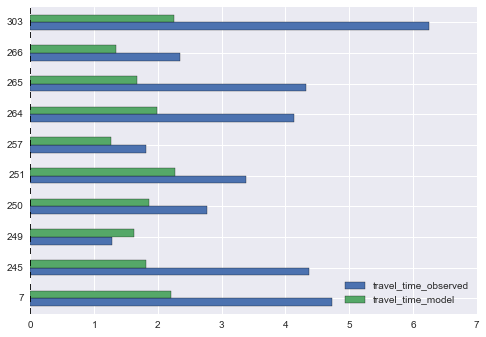

In [22]:
top_df[['travel_time_observed','travel_time_model']].plot(kind='barh')

# Worst performing OD pairs

In [23]:
import folium
import vincent
import json
vincent.core.initialize_notebook()

In [24]:
taz = pd.read_csv(r'..\data\gis\taz2010_centroids.txt')
taz_df = pd.merge(df_geog, taz[['TAZ','lat','lon']], left_on='dtaz',right_on='TAZ',how='inner')

In [25]:
worst_performing_taz_list = taz_df.sort('%_diff',ascending=False)[0:10]['dtaz'].values

In [26]:
map_osm = folium.Map(location=[47.636, -122.3750], zoom_start=11, tiles='Stamen Toner')

for taz in np.append(worst_performing_taz_list,origin_zone):
    color='red'
    if taz==origin_zone:
        color='green'
    coord = [taz_df[taz_df['dtaz'] == taz][col].values[0] for col in ['lat','lon']]
    icon = folium.Icon(color=color, icon="ok")
    
    marker = folium.Marker(location=coord,icon=icon, popup=str(taz))

    map_osm.add_children(marker);

map_osm.save('osm.html')

In [27]:
map_osm

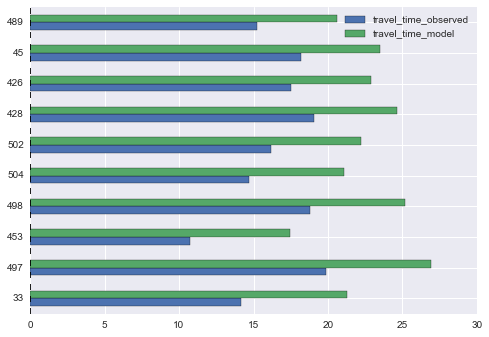

In [28]:
taz_df.sort('%_diff',ascending=False)[0:10][['travel_time_observed','travel_time_model']].plot(kind='barh')

In [29]:
taz_df[taz_df['dtaz'] == 573][['travel_time_observed','travel_time_model']]

,travel_time_observed,travel_time_model
303,6.25,2.25


# Look up TAZ on Map

In [30]:
TAZ_LIST = [522,573]

map_osm = folium.Map(location=[47.636, -122.3750], zoom_start=11, tiles='Stamen Toner')

for taz in TAZ_LIST:
    color='green'
    coord = [taz_df[taz_df['dtaz'] == taz][col].values[0] for col in ['lat','lon']]
    icon = folium.Icon(color=color, icon="ok")
    
    marker = folium.Marker(location=coord,icon=icon, popup=str(taz))

    map_osm.add_children(marker);

map_osm.save('osm.html')
map_osm

# Seasonal Variation